# Regression with Text Input Using BERT and Transformers

- Based on this [medium blog post](https://lajavaness.medium.com/regression-with-text-input-using-bert-and-transformers-71c155034b13);

## Setup

In [45]:
%%time

# Load packages.
import torch

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from datasets import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from evaluate.loading import load
from torch.utils.data import DataLoader

CPU times: user 106 μs, sys: 4 μs, total: 110 μs
Wall time: 117 μs


## Dataset

### Download

In [2]:
!pwd

/llm_app


In [3]:
!wget \
    https://gist.githubusercontent.com/ljnmedium/177b80072f04d1ed6f1ca127c053881a/raw/a8c9985abea89abb9f7d75a788206c1324d7fe1c/nhutljn-regression-sentiments.train.jsonlines \
    -O /llm_app/notebooks/tutorials/regression-sentiments.train.jsonlines


--2024-12-27 03:42:08--  https://gist.githubusercontent.com/ljnmedium/177b80072f04d1ed6f1ca127c053881a/raw/a8c9985abea89abb9f7d75a788206c1324d7fe1c/nhutljn-regression-sentiments.train.jsonlines
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245947 (240K) [text/plain]
Saving to: ‘/llm_app/notebooks/tutorials/regression-sentiments.train.jsonlines’

/llm_app/notebooks/ 100%[===================>] 240.18K  --.-KB/s    in 0.04s   

2024-12-27 03:42:08 (6.28 MB/s) - ‘/llm_app/notebooks/tutorials/regression-sentiments.train.jsonlines’ saved [245947/245947]



In [4]:
!wget \
    https://gist.githubusercontent.com/ljnmedium/94b5ea0a383976e5b40a2d2a85dadf40/raw/a37f5e81db3aac36d4d0eb8d98f0a22758fc283b/nhutljn-regression-sentiments.validation.jsonlines \
    -O /llm_app/notebooks/tutorials/regression-sentiments.validation.jsonlines

--2024-12-27 03:42:10--  https://gist.githubusercontent.com/ljnmedium/94b5ea0a383976e5b40a2d2a85dadf40/raw/a37f5e81db3aac36d4d0eb8d98f0a22758fc283b/nhutljn-regression-sentiments.validation.jsonlines
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53162 (52K) [text/plain]
Saving to: ‘/llm_app/notebooks/tutorials/regression-sentiments.validation.jsonlines’

/llm_app/notebooks/ 100%[===================>]  51.92K  --.-KB/s    in 0.02s   

2024-12-27 03:42:10 (2.98 MB/s) - ‘/llm_app/notebooks/tutorials/regression-sentiments.validation.jsonlines’ saved [53162/53162]



In [5]:
!wget \
    https://gist.githubusercontent.com/ljnmedium/d3c5984c62f4df157e85a5d4d6035272/raw/8ec34e678c9255e146c24ec3eae7e16b6e3d1df0/nhutljn-regression-bert-sentiments.test.jsonlines \
    -O /llm_app/notebooks/tutorials/regression-sentiments.test.jsonlines

--2024-12-27 03:42:11--  https://gist.githubusercontent.com/ljnmedium/d3c5984c62f4df157e85a5d4d6035272/raw/8ec34e678c9255e146c24ec3eae7e16b6e3d1df0/nhutljn-regression-bert-sentiments.test.jsonlines
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54424 (53K) [text/plain]
Saving to: ‘/llm_app/notebooks/tutorials/regression-sentiments.test.jsonlines’

/llm_app/notebooks/ 100%[===================>]  53.15K  --.-KB/s    in 0.03s   

2024-12-27 03:42:11 (1.49 MB/s) - ‘/llm_app/notebooks/tutorials/regression-sentiments.test.jsonlines’ saved [54424/54424]



### Understanding

In [31]:
raw_train_ds = Dataset.from_json("/llm_app/notebooks/tutorials/regression-sentiments.train.jsonlines")
raw_val_ds = Dataset.from_json("/llm_app/notebooks/tutorials/regression-sentiments.validation.jsonlines")
raw_test_ds = Dataset.from_json("/llm_app/notebooks/tutorials/regression-sentiments.test.jsonlines")

# Alex: reduce datasets by half the original size (in order to avoid memory and time constraints).
idx_train = np.random.choice(
    a=np.arange(raw_train_ds.num_rows), 
    size=int(raw_train_ds.num_rows/2),
    replace=False
)
idx_train.sort()
raw_train_ds = raw_train_ds.select(idx_train)

idx_val = np.random.choice(
    a=np.arange(raw_val_ds.num_rows), 
    size=int(raw_val_ds.num_rows/2),
    replace=False
)
idx_val.sort()
raw_val_ds = raw_val_ds.select(idx_val)

idx_test = np.random.choice(
    a=np.arange(raw_test_ds.num_rows), 
    size=int(raw_test_ds.num_rows/2),
    replace=False
)
idx_test.sort()
raw_test_ds = raw_test_ds.select(idx_test)

# This line prints the description of train_ds.
raw_train_ds, raw_val_ds, raw_test_ds

(Dataset({
     features: ['id', 'text', 'uuid', 'score'],
     num_rows: 330
 }),
 Dataset({
     features: ['id', 'text', 'uuid', 'score'],
     num_rows: 71
 }),
 Dataset({
     features: ['id', 'text', 'uuid', 'score'],
     num_rows: 71
 }))

In [32]:
raw_train_ds[0]

{'id': 457,
 'text': 'Trop désagréable au téléphone 😡! ! !',
 'uuid': '91c4efaaada14a1b9b050268185b6ae5',
 'score': 1}

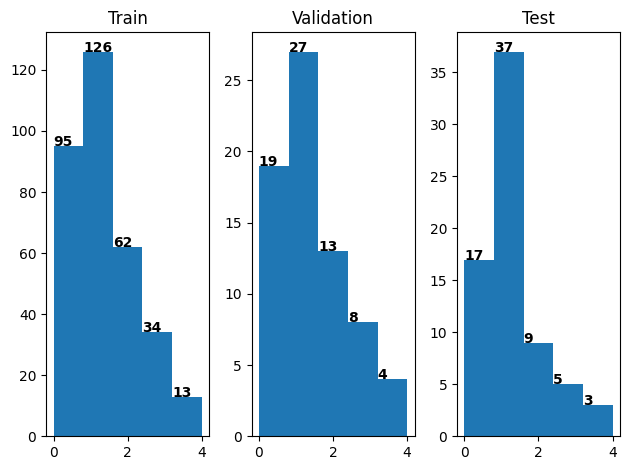

In [33]:
fig, axs = plt.subplots(1, 3, tight_layout=True)
distributions = []

axs[0].set_title("Train"); axs[1].set_title("Validation"); axs[2].set_title("Test"); 
train_distributions = axs[0].hist(raw_train_ds["score"], bins=5)
val_distributions = axs[1].hist(raw_val_ds["score"], bins=5)
test_distributions = axs[2].hist(raw_test_ds["score"], bins=5)

for distributions, ax in zip([train_distributions, val_distributions, test_distributions], axs):
    for j in range(5):
        # Display the counts on each column of the histograms
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")


## Fine-tuning with a Text Classification Model

In [34]:
%%time

BASE_MODEL = "camembert-base"
LEARNING_RATE = 2e-5
MAX_LENGTH = 28 # 256
BATCH_SIZE = 4  # 16
EPOCHS = 1      # 20

# Let's name the classes 0, 1, 2, 3, 4 like their indices.
id2label = {k:k for k in range(5)}
label2id = {k:k for k in range(5)}

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, id2label=id2label, label2id=label2id)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 387 ms, sys: 24.2 ms, total: 411 ms
Wall time: 776 ms


### Prepare Datasets

In [35]:
%%time

ds = {"train": raw_train_ds, "validation": raw_val_ds, "test": raw_test_ds}


def preprocess_function(examples):
    
    label = examples["score"] 
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    examples["label"] = label

    return examples


for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["id", "uuid", "text", "score"])

Map:   0%|          | 0/330 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

CPU times: user 838 ms, sys: 36.7 ms, total: 875 ms
Wall time: 902 ms


### Metrics

In [36]:
metric = load("accuracy")

def compute_metrics(eval_pred):
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    return metric.compute(predictions=predictions, references=labels)

In [37]:
training_args = TrainingArguments(
    output_dir="/llm_app/models/camembert-fine-tuned-regression",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

/usr/local/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [38]:
%%time

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.439683,0.380282


CPU times: user 22min 7s, sys: 51.8 s, total: 22min 59s
Wall time: 11min 50s


TrainOutput(global_step=83, training_loss=1.4856177640248494, metrics={'train_runtime': 710.2054, 'train_samples_per_second': 0.465, 'train_steps_per_second': 0.117, 'total_flos': 43414493506560.0, 'train_loss': 1.4856177640248494, 'epoch': 1.0})

### Evaluation

In [41]:
%%time

trainer.evaluate()

CPU times: user 1min 11s, sys: 151 ms, total: 1min 11s
Wall time: 36.4 s


{'eval_loss': 1.4396826028823853,
 'eval_accuracy': 0.38028169014084506,
 'eval_runtime': 36.4186,
 'eval_samples_per_second': 1.95,
 'eval_steps_per_second': 0.494,
 'epoch': 1.0}

In [42]:
%%time

trainer.eval_dataset=ds["test"]
trainer.evaluate()

CPU times: user 1min 4s, sys: 141 ms, total: 1min 4s
Wall time: 32.5 s


{'eval_loss': 1.3512624502182007,
 'eval_accuracy': 0.5211267605633803,
 'eval_runtime': 32.538,
 'eval_samples_per_second': 2.182,
 'eval_steps_per_second': 0.553,
 'epoch': 1.0}

### Prediction

In [48]:
input_texts = [
    "C'est très bien", 
    "Je vais y aller.", 
    "J'en ai marre.", 
    "Vous ne foutez rien !!!", 
    "Je vous remercie infiniment pour cet excellent service !!!"
]

# Encode the text.
encoded = tokenizer(
    input_texts, 
    truncation=True, 
    padding="max_length", 
    max_length=28, # 256
    return_tensors="pt"
)#.to("cuda")

# Call the model to predict under the format of logits of 5 classes
logits = model(**encoded).logits

# Get the class
torch.argmax(logits, axis=1)

tensor([1, 1, 1, 1, 1])

## Fine-tuning with a Regression Model